In [18]:
from __future__ import print_function, division
import time
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

rcParams['figure.figsize'] = (13, 6)

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, FHMM

In [12]:
train = DataSet('./REDD/redd.h5')
test = DataSet('./REDD/redd.h5')

In [13]:
building = 1

In [14]:
train.set_window(end="30-4-2011")
test.set_window(start="30-4-2011")


train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

In [23]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

15/16 MeterGroup(meters==19, building=1, dataset='REDD', appliances=[Appliance(type='unknown', instance=2)])e=1)])ce=1)])
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters= for ElecMeterID(instance=4, building=1, dataset='REDD') ...   
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

# Training and disaggregation

## FHMM

In [57]:
start = time.time()
from nilmtk.disaggregate import fhmm_exact
fhmm = fhmm_exact.FHMM()
# Note that we have given the sample period to downsample the data to 1 minute. 
# If instead of top_5 we wanted to train on all appliance, we would write 
# fhmm.train(train_elec, sample_period=60)
fhmm.train(top_5_train_elec, sample_period=60)
end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Runtime = 16.8914110661 seconds.


In [58]:
pred = {}
gt= {}

for i, chunk in enumerate(test_elec.mains().load(sample_period=60)):
    chunk_drop_na = chunk.dropna()
    pred[i] = fhmm.disaggregate_chunk(chunk_drop_na)
    gt[i]={}
    
    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt[i][meter] = meter.load(sample_period=60).next()
    gt[i] = pd.DataFrame({k:v.squeeze() for k,v in gt[i].iteritems()}, index=gt[i].values()[0].index).dropna()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


In [59]:
# If everything can fit in memory
gt_overall = pd.concat(gt)
gt_overall.index = gt_overall.index.droplevel()
pred_overall = pd.concat(pred)
pred_overall.index = pred_overall.index.droplevel()

# Having the same order of columns
gt_overall = gt_overall[pred_overall.columns]

In [60]:
#Intersection of index
gt_index_utc = gt_overall.index.tz_convert("UTC")
pred_index_utc = pred_overall.index.tz_convert("UTC")
common_index_utc = gt_index_utc.intersection(pred_index_utc)

In [61]:
local_timezone = train.metadata['timezone']

In [62]:
common_index_local = common_index_utc.tz_convert(local_timezone)

In [63]:
gt_overall = gt_overall.ix[common_index_local]
pred_overall = pred_overall.ix[common_index_local]

In [64]:
appliance_labels = [m.label() for m in gt_overall.columns.values]
gt_overall.columns = appliance_labels
pred_overall.columns = appliance_labels

In [65]:
pred_overall.head()

,Microwave,Sockets,Light,Fridge,Dish washer
2011-04-30 00:01:00-04:00,1091.0,22.0,2.0,192.0,0.0
2011-04-30 00:02:00-04:00,1091.0,22.0,2.0,192.0,0.0
2011-04-30 00:03:00-04:00,1091.0,22.0,2.0,192.0,0.0
2011-04-30 00:04:00-04:00,1091.0,22.0,2.0,192.0,0.0
2011-04-30 00:05:00-04:00,1091.0,22.0,2.0,192.0,0.0


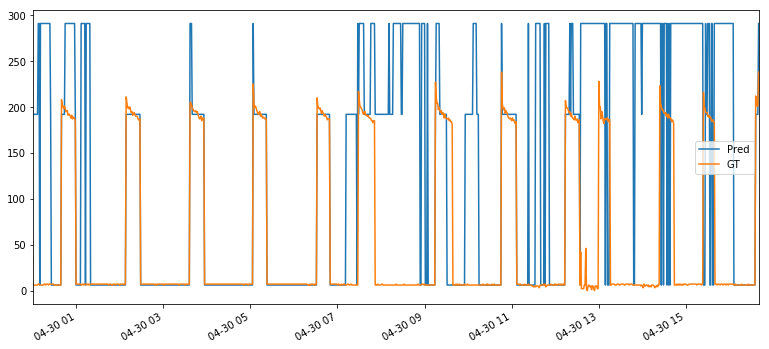

In [66]:
pred_overall['Fridge'].head(1000).plot(label="Pred")
gt_overall['Fridge'].head(1000).plot(label="GT")
plt.legend()

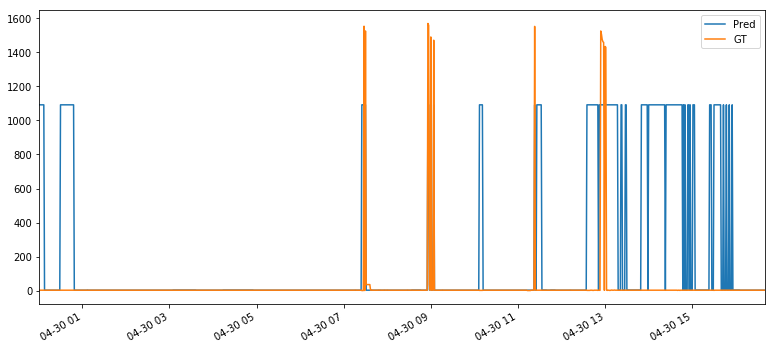

In [67]:
pred_overall['Microwave'].head(1000).plot(label="Pred")
gt_overall['Microwave'].head(1000).plot(label="GT")
plt.legend()

In [68]:
from sklearn.metrics import mean_squared_error

In [69]:
rms_error_fhmm = {}
for appliance in gt_overall.columns:
    rms_error_fhmm[appliance] = np.sqrt(mean_squared_error(gt_overall[appliance], pred_overall[appliance]))

In [70]:
pd.Series(rms_error_fhmm)

Dish washer    237.469699
Fridge          98.303702
Light           82.262046
Microwave      250.434489
Sockets         38.968234
dtype: float64

## Combinatorial Optimization

In [72]:
start = time.time()
co = CombinatorialOptimisation()
# Note that we have given the sample period to downsample the data to 1 minute. 
# If instead of top_5 we wanted to train on all appliance, we would write 
# fhmm.train(train_elec, sample_period=60)
co.train(top_5_train_elec, sample_period=60)
end = time.time()
print("Runtime =", end-start, "seconds.")

Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Done training!
Runtime = 1.34301686287 seconds.


In [73]:
pred = {}
gt= {}

for i, chunk in enumerate(test_elec.mains().load(sample_period=60)):
    chunk_drop_na = chunk.dropna()
    pred[i] = co.disaggregate_chunk(chunk_drop_na)
    gt[i]={}
    
    for meter in test_elec.submeters().meters:
        # Only use the meters that we trained on (this saves time!)    
        gt[i][meter] = meter.load(sample_period=60).next()
    gt[i] = pd.DataFrame({k:v.squeeze() for k,v in gt[i].iteritems()}, index=gt[i].values()[0].index).dropna()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Estimating power demand for 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Estimating power demand for 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Estimating power demand for 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Estimating power demand for 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Estimating power demand for 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
Loading data for meter ElecMeterID(instance=4, building=1, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=20, building=1, dataset='REDD')     
Done 

In [74]:
# If everything can fit in memory
gt_overall = pd.concat(gt)
gt_overall.index = gt_overall.index.droplevel()
pred_overall = pd.concat(pred)
pred_overall.index = pred_overall.index.droplevel()

# Having the same order of columns
gt_overall = gt_overall[pred_overall.columns]

In [75]:
#Intersection of index
gt_index_utc = gt_overall.index.tz_convert("UTC")
pred_index_utc = pred_overall.index.tz_convert("UTC")
common_index_utc = gt_index_utc.intersection(pred_index_utc)

In [76]:
gt_overall = gt_overall.ix[common_index_local]
pred_overall = pred_overall.ix[common_index_local]

In [77]:
appliance_labels = [m.label() for m in gt_overall.columns.values]
gt_overall.columns = appliance_labels
pred_overall.columns = appliance_labels

In [78]:
pred_overall.head()

,Microwave,Sockets,Light,Fridge,Dish washer
2011-04-30 00:01:00-04:00,0.0,0.0,0.0,199.0,1107.0
2011-04-30 00:02:00-04:00,0.0,0.0,0.0,199.0,1107.0
2011-04-30 00:03:00-04:00,0.0,0.0,0.0,199.0,1107.0
2011-04-30 00:04:00-04:00,0.0,0.0,0.0,199.0,1107.0
2011-04-30 00:05:00-04:00,0.0,0.0,0.0,199.0,1107.0


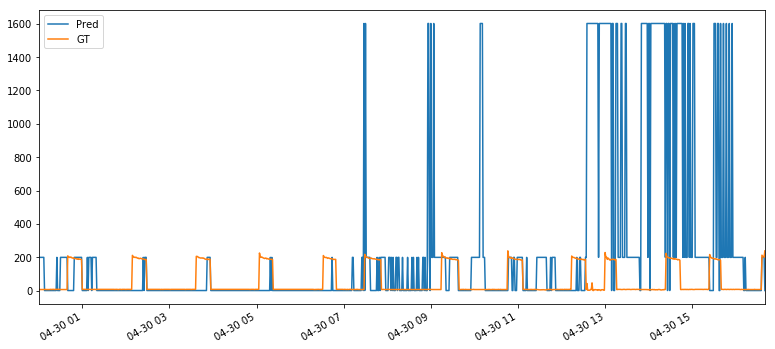

In [79]:
pred_overall['Fridge'].head(1000).plot(label="Pred")
gt_overall['Fridge'].head(1000).plot(label="GT")
plt.legend()

In [80]:
rms_error_co = {}
for appliance in gt_overall.columns:
    rms_error_co[appliance] = np.sqrt(mean_squared_error(gt_overall[appliance], pred_overall[appliance]))

In [84]:
rms_error_fhmm

{'Dish washer': 237.46969876454827,
 'Fridge': 98.303702022483876,
 'Light': 82.26204627304206,
 'Microwave': 250.43448862401016,
 'Sockets': 38.968234411796111}

In [94]:
rms_error_co

{'Dish washer': 223.30167,
 'Fridge': 274.49606,
 'Light': 96.534035,
 'Microwave': 264.92465,
 'Sockets': 32.610813}

In [99]:
pd.DataFrame([rms_error_fhmm, rms_error_co], index = ['FHMM', 'CO']).T

,FHMM,CO
Dish washer,237.469699,223.301666
Fridge,98.303702,274.496063
Light,82.262046,96.534035
Microwave,250.434489,264.924652
Sockets,38.968234,32.610813
